In [9]:
import numpy as np
from astropy.modeling import models

import matplotlib.pyplot as plt

In [10]:
g = models.Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5)
g

<Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5)>

In [11]:
xx = np.linspace(-5.0, 5.0, 2000)

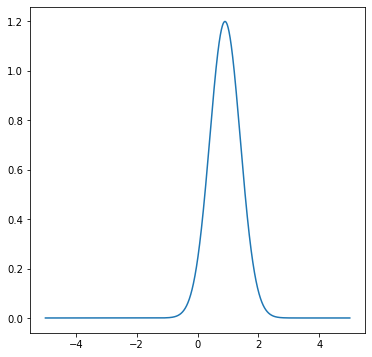

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(xx, g(xx))

In [13]:
img = np.zeros((1000, 1000), dtype=np.float32)

In [14]:
modlist = [models.Gaussian2D(amplitude=1200, x_mean=250, y_mean=250, x_stddev=15, y_stddev=15),
           models.Gaussian2D(amplitude=1200000, x_mean=750, y_mean=750, x_stddev=15, y_stddev=15),]

notice orientation of the axes in the code above and the figure below. $x\_mean$ is the column coordinate in the image matrix, $y\_mean$ is the row index

In [15]:
for model in modlist:
    model.render(img)

The code below doesn't work. Attempted to make compound model and then render it once. The compound model is fine, the rendering not so much.

In [16]:
# x_means = np.array([250, 750])
# y_means = np.array([750, 750])
# amps = np.array([1200, 1200])
# vecmod = models.Gaussian2D(amplitude=amps, x_mean=x_means, y_mean=y_means, x_stddev=15)
# img = np.zeros((1000, 1000), dtype=np.float32)
# vecmod.render(img)

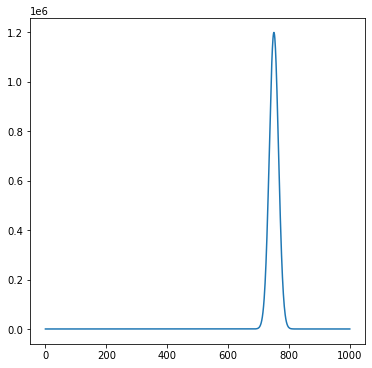

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(img[750])

In [18]:
img[750,750], img.max()

(1200000.0, 1200000.0)

In [19]:
img[250].sum()

45119.31

In [20]:
modlist[0].x_stddev.value, modlist[0].x_fwhm, modlist[0].x_fwhm/2.35482, modlist[0].x_stddev.value*2.35482

(15.0, 35.32230067546424, 15.000000286843257, 35.3223)

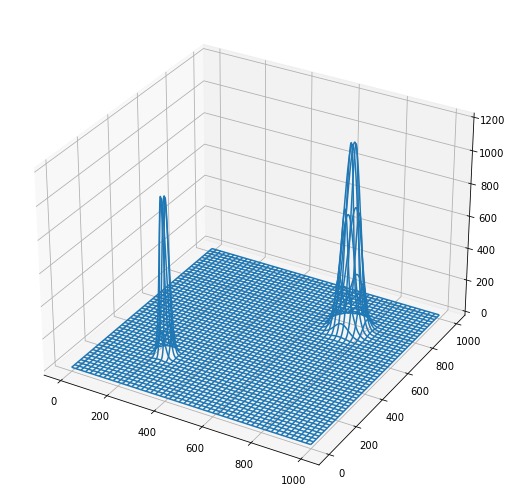

In [14]:
XX, YY = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9,9))
ax.plot_wireframe(XX,YY, img, cstride=20, rstride=20)#, antialiased=False, cmap=plt.cm.gist_heat, vmin=0, vmax=3)


In [15]:
from astropy.table import Table
tbl = Table.read(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\xmatch_tables\clarisse')
all_flux = np.array(tbl['phot_g_mean_flux'].filled(fill_value=0.0))

In [16]:
n_stars = 1000
n_xpix = 1000
n_ypix = 1000
radius = 35

x_pix = np.arange(n_xpix)
y_pix = np.arange(n_ypix)

x_0 = np.random.choice(x_pix, n_stars)
y_0 = np.random.choice(y_pix, n_stars)
flux = np.random.choice(all_flux, n_stars)
img = np.zeros((n_xpix, n_ypix), dtype=np.float32)

for x,y,f in zip(x_0, y_0, flux):
    #model = models.AiryDisk2D(amplitude=flux, x_0=x, y_0=y, radius=radius)
    model = models.Gaussian2D(amplitude=f, x_mean=x, y_mean=y, x_stddev=radius/10.0, y_stddev=radius/10.0)
    model.render(img)


In [17]:
img.max(), flux.max()

(350775.75, 350775.7628671831)

In [18]:
img += np.random.normal(loc=30, scale=3, size=img.shape)

In [19]:
model.bounding_box

((235.75, 274.25), (465.75, 504.25))

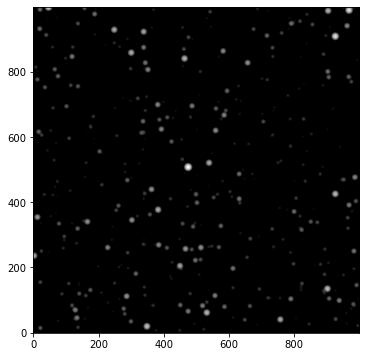

In [20]:
import matplotlib.colors as colors
vmin=300; vmax=None

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.clip(img,vmin, vmax), origin='lower', cmap='gray', norm=colors.LogNorm())

In [21]:
from astropy.wcs import WCS
import ccdproc as ccdp
from astropy.nddata import CCDData
from astropy.time import Time
from astropy.io import fits

In [22]:
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\no_bias\SUPA01564807.fits') as f:
    hdr = f[0].header.copy()
    data = f[0].data.copy()

In [23]:
hdr['DETECTOR']

'clarisse'

In [24]:
from astropy.coordinates import SkyCoord
import astropy.units as u

wcs = WCS(hdr)
xmatch_tbl = Table.read(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\xmatch_tables\clarisse')
t_obs = Time(hdr['MJD'], scale='utc', format='mjd')
#hard code for gaia dr3:
t_gaia = Time(2016, scale='tcb',format='jyear')

coords_gaia = SkyCoord(ra = xmatch_tbl['ra']*u.degree, dec = xmatch_tbl['dec']*u.degree,
                pm_ra_cosdec = xmatch_tbl['pmra'].filled(fill_value=0.0)*u.mas/u.year,
                pm_dec = xmatch_tbl['pmdec'].filled(fill_value=0.0)*u.mas/u.year,
                radial_velocity = xmatch_tbl['radial_velocity'].filled(fill_value=0.0)*u.km/u.second,
                distance = 1000.0/np.abs(xmatch_tbl['parallax']) * u.pc,
                obstime = t_gaia)

#move the positions to the obs time and reframe to FK5
t_2000 = Time('J2000.0',  format='jyear_str')
coords = coords_gaia.apply_space_motion(new_obstime=t_2000).fk5

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
c:\Users\Kevin\anaconda3\envs\astro\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 39 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [25]:
wcs = WCS(hdr)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [26]:
in_image = wcs.footprint_contains(coords)
coords_in_image = coords[in_image]


In [27]:
wcs.world_to_pixel_values(coords_in_image.ra, coords_in_image.dec)

(array([2147.76489212, 2130.32258762, 2243.90287655, ..., 1747.22022674,
        1738.88859984, 1891.07234138]),
 array([  47.62188455,   70.02593029,    6.5159512 , ..., 4222.95372015,
        4212.51034632, 4269.74207878]))

In [28]:
zz=wcs.world_to_array_index(coords_in_image)

In [29]:
type(zz)

tuple

In [30]:
zz[0][0],zz[1][0]

(48, 2148)

In [31]:
coords_in_image[0],wcs.world_to_array_index(coords_in_image[0])

(<SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, pc)
     (270.96752546, -24.38312572, 1098.26737322)
  (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
     (0.46926429, -2.14425467, 3.39831062)>,
 (48, 2148))

In [32]:
wcs.world_to_pixel(coords_in_image[0])

(array(2147.76489212), array(47.62188455))

In [33]:
yy=wcs.world_to_array_index_values(coords_in_image.ra, coords_in_image.dec)

In [34]:
wcs.printwcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 270.90375  -24.38665278  
CRPIX : 3184.0  -14.0  
PC1_1 PC1_2  : -5.611e-05  0.0  
PC2_1 PC2_2  : 0.0  5.611e-05  
CDELT : 1.0  1.0  
NAXIS : 2272  4273


In [35]:
wcs.pixel_to_world(hdr['CRPIX1']-1, hdr['CRPIX2']-1) #need to subtract 1 for python indexing

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (270.90375, -24.38665278)>

In [36]:
#the ra dimension is first are, the dec the second.
#return result is in python indexing scheme, e.g. has the -1 subtracted
wcs.world_to_array_index_values(hdr['CRVAL1'], hdr['CRVAL2'])

(array(-15), array(3183))

In [37]:
data.shape, hdr['NAXIS1'], hdr['NAXIS2']

((4273, 2272), 2272, 4273)

NAXIS1 is the horizontal dimension, the RA dimenstion, NAXIS2 the vertical, declination

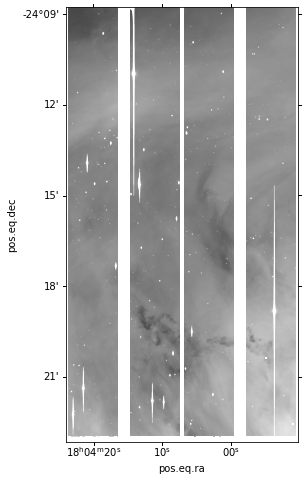

In [38]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=wcs)
ax.imshow(data, origin='lower', cmap='gray', norm=colors.LogNorm(vmin=500, vmax=30000))

In [95]:
from astropy.modeling import models

def false_image(hdr, coords, flux, scale=10.0):
    """
    flux: astropy table column (masked array), isomorphic to coords
    """
    # image shape
    s = (hdr['NAXIS2'], hdr['NAXIS1'])
    gain = hdr['GAIN'] #adu per electron

    # convert the seeing to FWHM in decimal degrees, then to pixels:
    seeing = hdr['SEEING']/3600.0 #seeing is in arcsec
    see_pix = seeing/(np.abs(hdr['CDELT1']*hdr['PC1_1'])) #FWHM in pixels
    stddev = see_pix * 2.35482/scale # see http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn2.html

    wcs = WCS(hdr)
 
    #just deal with the xmatches that are in the image and have a flux value
    in_image = np.logical_and(wcs.footprint_contains(coords), ~flux.mask)

    pxs = wcs.world_to_array_index(coords[in_image])

    img = np.zeros(s, dtype=np.float32)

    for i,f in enumerate(flux[in_image]):
        mod = models.Gaussian2D(amplitude=f/gain, x_mean=pxs[1][i], y_mean=pxs[0][i], x_stddev=stddev, y_stddev=stddev)
        mod.render(img)
    
    return img

In [96]:
false_img = false_image(hdr, coords, xmatch_tbl['phot_g_mean_flux'])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


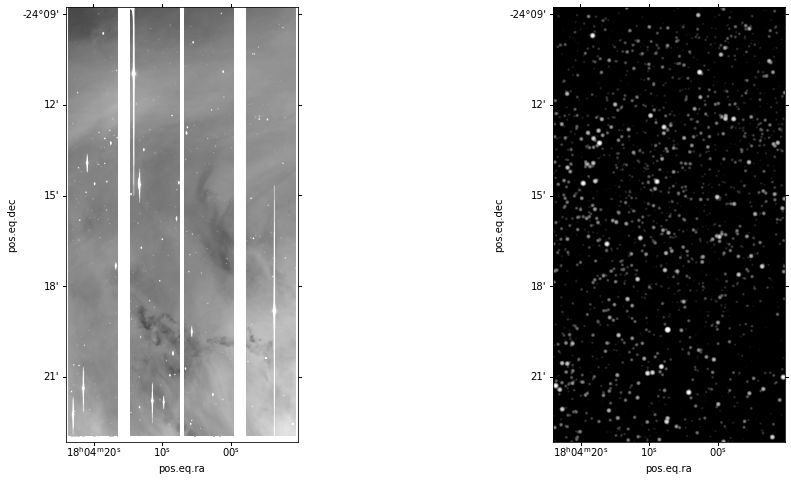

In [116]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, projection=wcs)
ax1.imshow(data, origin='lower', cmap='binary_r', norm=colors.LogNorm(vmin=500, vmax=30000))
ax2 = plt.subplot(122, projection=wcs)
ax2.imshow(np.clip(false_img, a_min=100, a_max=60000),  origin='lower', cmap='binary_r', norm=colors.LogNorm())

In [78]:
false_img.min(), false_img.max()

(0.0, 1014679.0)

In [ ]:
zz=false_img.flatten()
(zz!=0.0).sum(), zz[zz!=0].min()

(4937, 51.923363)

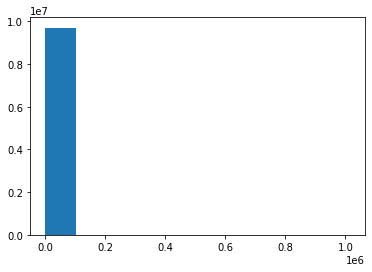

In [80]:
from astropy.visualization import hist
qq=hist(false_img.flatten())